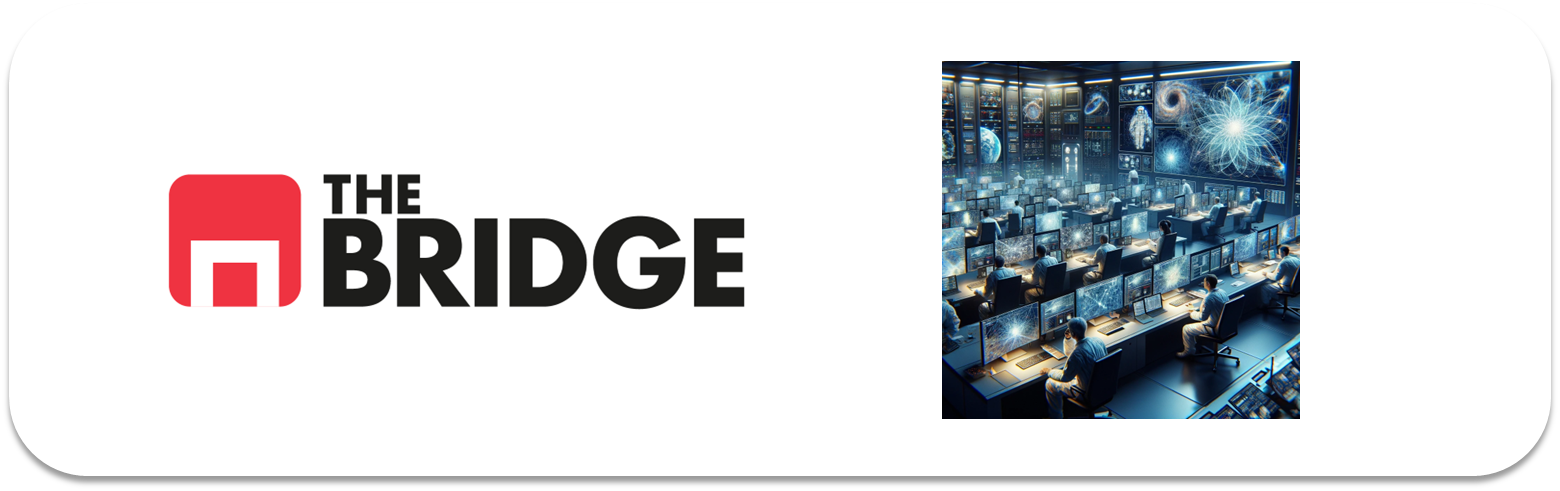

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2
import bootcampviztools as bt

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [300]:
ROOT_PATH = './data/'
TRAIN_0 = ROOT_PATH + "github_train_0"
TRAIN_1 = ROOT_PATH + "github_train_1"
TRAIN_2 = ROOT_PATH + "github_train_2"
TRAIN_3 = ROOT_PATH + "github_train_3"
TEST_PATH = ROOT_PATH + "github_test"

train_dirs = [TRAIN_0, TRAIN_1, TRAIN_2, TRAIN_3]

In [301]:
import os
import numpy as np
import cv2
from imageio import imread
from tqdm import tqdm

def read_multiple_dirs(directories, reshape_dim=(32,32)):
    X, y = [], []
    for directory in directories:
        print(f"Leyendo imágenes desde: {directory}")
        for file in tqdm(os.listdir(directory)):
            file_path = os.path.join(directory, file)

            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            try:
                image = imread(file_path)
                image = cv2.resize(image, reshape_dim)
                X.append(image)

                # Etiqueta desde el nombre del archivo
                label = 'dog' if 'dog' in file.lower() else 'cat'
                y.append(label)
            except Exception as e:
                print(f"Error en {file_path}: {e}")

    return np.array(X), np.array(y)

In [302]:
X_train, y_train = read_multiple_dirs(train_dirs)
X_test, y_test = read_multiple_dirs([TEST_PATH])

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Leyendo imágenes desde: ./data/github_train_0


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 570.98it/s]


Leyendo imágenes desde: ./data/github_train_1


100%|██████████| 1000/1000 [00:01<00:00, 566.47it/s]


Leyendo imágenes desde: ./data/github_train_2


100%|██████████| 1000/1000 [00:01<00:00, 602.83it/s]


Leyendo imágenes desde: ./data/github_train_3


100%|██████████| 1000/1000 [00:01<00:00, 592.49it/s]


Leyendo imágenes desde: ./data/github_test


100%|██████████| 1000/1000 [00:01<00:00, 583.79it/s]

Train: (4000, 32, 32, 3), (4000,)
Test: (1000, 32, 32, 3), (1000,)


In [303]:
print(X_train.shape)
print(y_train.shape)

(4000, 32, 32, 3)
(4000,)


*4000 imagenes de 64x64 con 3 canales para los colores en el train*

In [304]:
print(X_test.shape)
print(y_test.shape)

(1000, 32, 32, 3)
(1000,)


*1000 imagenes en el test*

*Pintado de imágenes*

In [305]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

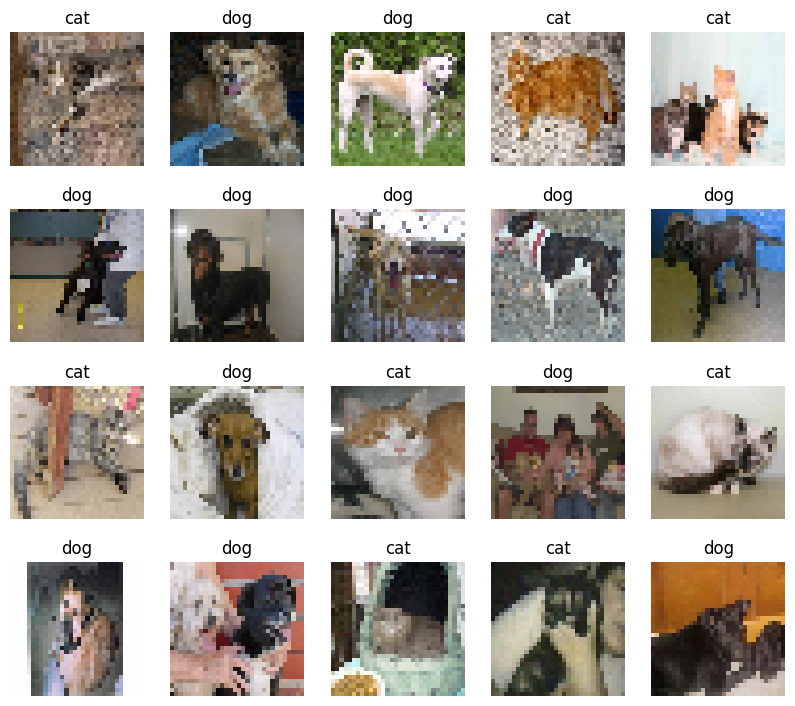

In [306]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

### Ahora hacemos un pequeño miniEda y normaliza las features

Veamos la distribución


In [307]:
targets = pd.Series(y_train)
targets.value_counts(True)

cat    0.5
dog    0.5
Name: proportion, dtype: float64

¡Perfecto! Ese resultado muestra que tenemos un dataset balanceado, es decir, un 50% de imágenes de gatos y 50% de perros. Eso es ideal porque evita problemas de sesgo hacia una clase durante el entrenamiento del modelo.

### La normalización de imágenes

In [308]:
X_train = X_train/255
X_test = X_test/255

In [328]:
X_train.dtype

dtype('float64')

### Diseñamos la arquitectura de la red. 

In [309]:
capas = [keras.layers.Conv2D(filters = 64, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 32, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

         keras.layers.Conv2D(filters = 16, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(2, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

In [310]:
X_train.size

12288000

In [311]:
model.compile(optimizer = 'adam', loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

### *Ahora el resumen del modelo*

In [312]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 150)            │        38,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,732 (307.55 KB)

 Trainable params: 78,732 (307.55 KB)

 Non-trainable params: 0 (0.00 B)

In [313]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'cat': 0, 'dog': 1}

In [314]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [315]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

### Entrenamos modelo

In [316]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5193 - loss: 0.6937 - val_accuracy: 0.6025 - val_loss: 0.6766
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5727 - loss: 0.6751 - val_accuracy: 0.6587 - val_loss: 0.6252
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6372 - loss: 0.6366 - val_accuracy: 0.6750 - val_loss: 0.6142
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6895 - loss: 0.5859 - val_accuracy: 0.6888 - val_loss: 0.5959
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7293 - loss: 0.5350 - val_accuracy: 0.6925 - val_loss: 0.5800
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7433 - loss: 0.5075 - val_accuracy: 0.7063 - val_loss: 0.5743
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7641 - loss: 0.4817 - val_accuracy: 0.7350 - val_loss: 0.5442
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8007 - loss: 0.4391 - val_acc

*Observando la evolución de la métrica:*

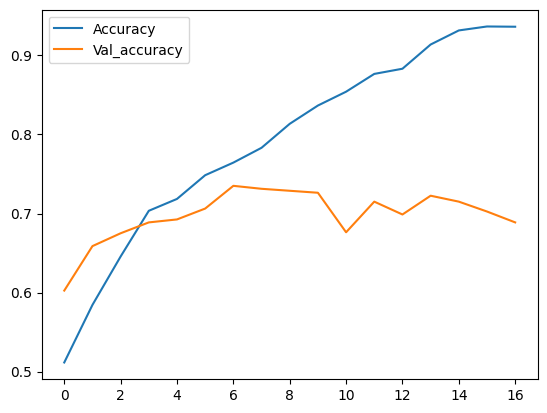

In [317]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

*Observando la evolución de la pérdida:*

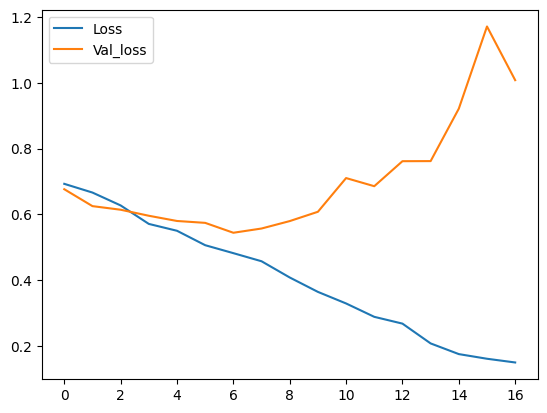

In [318]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

### Evaluamos el modelo

In [319]:
model.evaluate(X_test, y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7264 - loss: 0.5033


[0.5401987433433533, 0.7139999866485596]

### El modelo logra un rendimiento aceptable (75% accuracy), pero aún tiene margen de mejora. 

In [320]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [321]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

         cat       0.70      0.74      0.72       500
         dog       0.72      0.69      0.71       500

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



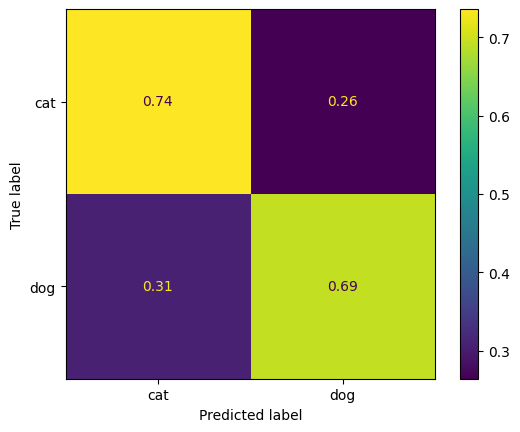

In [322]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

### Conclusión 

El modelo presenta un rendimiento sólido con una precisión global del 75% en la clasificación binaria de perros y gatos. Las métricas de precisión, recall y F1-score muestran un comportamiento equilibrado entre ambas clases, lo que refleja una capacidad razonable del modelo para generalizar sobre el conjunto de prueba. Sin embargo, un margen de error del 25% sugiere que existen imágenes visualmente complejas o difíciles de clasificar. 

In [323]:
confianza = [prediction.max() for prediction in model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [324]:
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

In [325]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
337,cat,dog,0.985986
680,dog,cat,0.983490
851,dog,cat,0.975841
97,cat,dog,0.973535
175,cat,dog,0.966697
...,...,...,...
973,dog,cat,0.502345
135,cat,dog,0.501682
631,dog,cat,0.500707
453,cat,dog,0.500306


In [326]:
for true_label, predicted_label in errores.iloc[0:10,0:2].values:
    print(true_label, predicted_label)

cat dog
dog cat
dog cat
cat dog
cat dog
dog cat
dog cat
dog cat
dog cat
dog cat


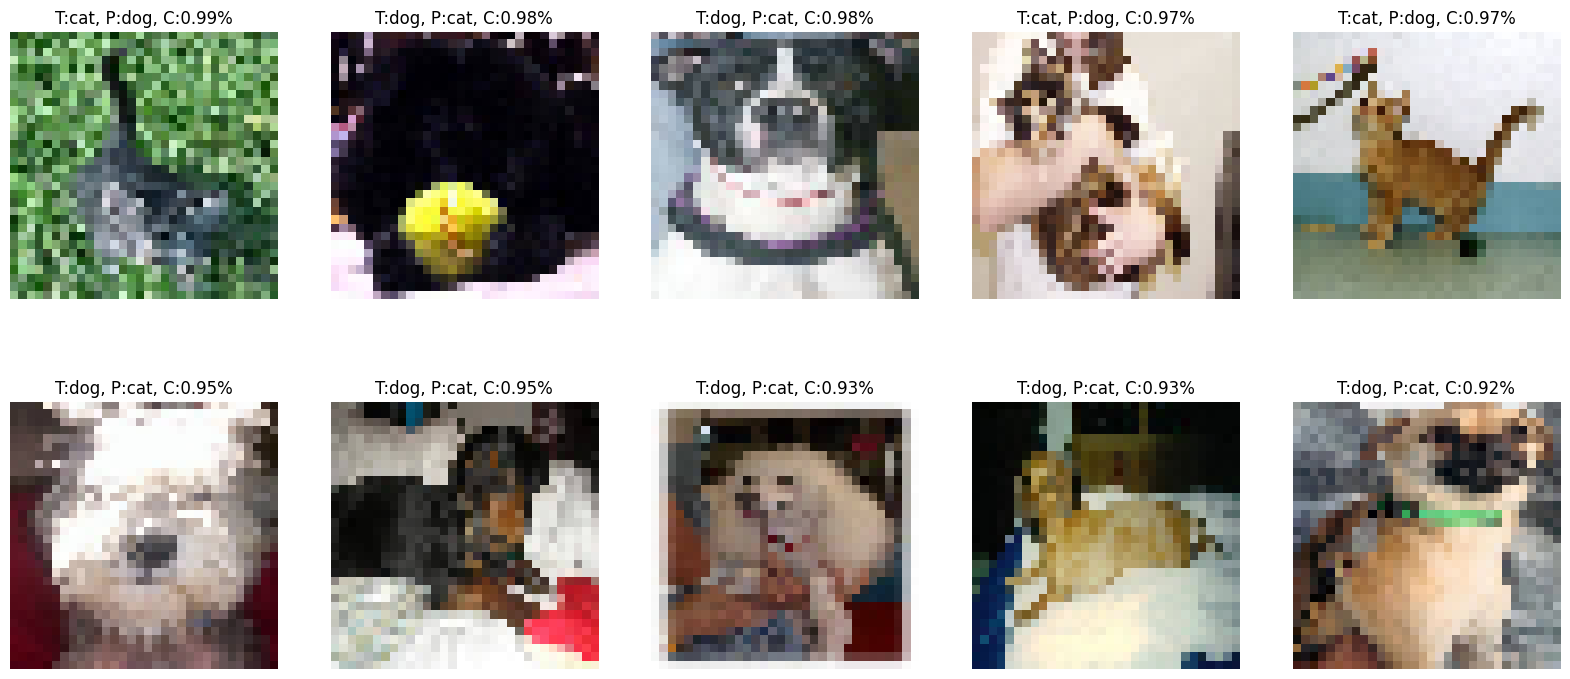

In [327]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)